In [2]:
#LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import seaborn as sns
from scipy import stats
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

The libraries i will be using on this analysis 

In [3]:
df = pd.read_csv("/home/blackest/data_analysis_learn/ship-ports/Port_Data.csv")

In [3]:
df.head(9)

,Unnamed: 0,Country,Port Name,UN Code,Vessels in Port,Departures(Last 24 Hours),Arrivals(Last 24 Hours),Expected Arrivals,Type,Area Local,Area Global,Also known as
0,0,China,SHANGHAI,CNSHG,2420,1376,1626,644,Port,East China Sea,Central China,"['SHANG HAI', ' YANGSHAN', ' CNSHA', ' CNSGH']"
1,1,China,NANTONG,CNNTG,1572,1173,1287,234,Port,East China Sea,Central China,['NAN TONG']
2,2,China,CJK,CNCJK,1529,343,370,310,Anchorage,East China Sea,Central China,"['CHANGJIANGKOU', ' CHANGJIANG KOU', ' CJK CN']"
3,3,China,NANJING,CNNKG,1414,667,1060,203,Port,East China Sea,Central China,"['NAN JING', ' NAN JIN', ' NANJIN']"
4,4,China,JIANGYIN,CNJIA,1112,1076,1070,166,Port,East China Sea,Central China,"['-', ' JANG JIN', ' JIANG YIN']"
5,5,Singapore,SINGAPORE,SGSIN,1109,1682,1748,1205,Port,Singapore Area,Indonesia,"['SPORE', ' SINGPORE', ' SIN EBGA', ' SIN PEBGA']"
6,6,China,ZHANGJIAGANG,CNZJG,1094,653,608,120,Port,East China Sea,Central China,"['ZHANG JIA GANG', ' ZHANG GIAN GANG', ' ZHAN ..."
7,7,China,ZHOUSHAN,CNZOS,1064,791,839,463,Port,East China Sea,Central China,"['ZHOU SHAN', ' DINGHAI', ' DING HAI', ' ZHOUS..."
8,8,China,YANGZHOU,CNYZH,945,654,786,47,Port,East China Sea,Central China,['YANG ZHOU']


Here am just checking what am dealing with ...Had already checked using Libre calc but i thought well no harm in  doing this ..its kind of a habit after all.
So we can see that there are some columns that need some work, first column(unnamed 0 is not relevant to the analysis and the last one("Also known as" needs some parsing ));

In [4]:
df.describe()

,Unnamed: 0,Vessels in Port,Departures(Last 24 Hours),Arrivals(Last 24 Hours),Expected Arrivals
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,239.500000,153.312500,98.981250,108.662500,39.233333
std,138.708327,217.297037,170.504574,185.357564,82.385289
min,0.000000,51.000000,0.000000,1.000000,0.000000
25%,119.750000,63.000000,26.750000,30.000000,3.000000
50%,239.500000,86.000000,48.000000,56.000000,16.000000
75%,359.250000,144.000000,102.000000,106.250000,40.250000
max,479.000000,2420.000000,1682.000000,1748.000000,1205.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 480 non-null    int64 
 1   Country                    480 non-null    object
 2   Port Name                  480 non-null    object
 3   UN Code                    468 non-null    object
 4   Vessels in Port            480 non-null    int64 
 5   Departures(Last 24 Hours)  480 non-null    int64 
 6   Arrivals(Last 24 Hours)    480 non-null    int64 
 7   Expected Arrivals          480 non-null    int64 
 8   Type                       480 non-null    object
 9   Area Local                 480 non-null    object
 10  Area Global                480 non-null    object
 11  Also known as              480 non-null    object
dtypes: int64(5), object(7)
memory usage: 45.1+ KB


checking for anything i might have missed ...but really am doing this because am going to be sharing this notebook to my students.

In [5]:
#STYLING and PREPING FOR ANALYSIS
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Load and prepare data and yes droping the irellevant column
df_clean = df.copy()
df_clean = df_clean.drop('Unnamed: 0', axis=1)

# Parse aliases ON THAT "ALSO KNOWN As" column
import ast
def safe_parse_aliases(alias_str):
    if pd.isna(alias_str) or alias_str == "[]" or alias_str == "['-']":
        return []
    try:
        cleaned = alias_str.replace("'", '"').replace('"', "'")
        return ast.literal_eval(cleaned)
    except:
        return [alias_str] if alias_str and alias_str != "-" else []

df_clean['Aliases_List'] = df_clean['Also known as'].apply(safe_parse_aliases)
df_clean['Alias_Count'] = df_clean['Aliases_List'].apply(len)

print(" ====>MARITIME PORT ANALYSIS INITIATED=========>")

 ====>MARITIME PORT ANALYSIS INITIATED=========>


removing the quotes in the names on that"Also known as column" I thought it would be easier for me to work well with the data

In [6]:
df_clean.head(10)

,Country,Port Name,UN Code,Vessels in Port,Departures(Last 24 Hours),Arrivals(Last 24 Hours),Expected Arrivals,Type,Area Local,Area Global,Also known as,Aliases_List,Alias_Count
0,China,SHANGHAI,CNSHG,2420,1376,1626,644,Port,East China Sea,Central China,"['SHANG HAI', ' YANGSHAN', ' CNSHA', ' CNSGH']","[SHANG HAI, YANGSHAN, CNSHA, CNSGH]",4
1,China,NANTONG,CNNTG,1572,1173,1287,234,Port,East China Sea,Central China,['NAN TONG'],[NAN TONG],1
2,China,CJK,CNCJK,1529,343,370,310,Anchorage,East China Sea,Central China,"['CHANGJIANGKOU', ' CHANGJIANG KOU', ' CJK CN']","[CHANGJIANGKOU, CHANGJIANG KOU, CJK CN]",3
3,China,NANJING,CNNKG,1414,667,1060,203,Port,East China Sea,Central China,"['NAN JING', ' NAN JIN', ' NANJIN']","[NAN JING, NAN JIN, NANJIN]",3
4,China,JIANGYIN,CNJIA,1112,1076,1070,166,Port,East China Sea,Central China,"['-', ' JANG JIN', ' JIANG YIN']","[-, JANG JIN, JIANG YIN]",3
5,Singapore,SINGAPORE,SGSIN,1109,1682,1748,1205,Port,Singapore Area,Indonesia,"['SPORE', ' SINGPORE', ' SIN EBGA', ' SIN PEBGA']","[SPORE, SINGPORE, SIN EBGA, SIN PEBGA]",4
6,China,ZHANGJIAGANG,CNZJG,1094,653,608,120,Port,East China Sea,Central China,"['ZHANG JIA GANG', ' ZHANG GIAN GANG', ' ZHAN ...","[ZHANG JIA GANG, ZHANG GIAN GANG, ZHAN JIANG]",3
7,China,ZHOUSHAN,CNZOS,1064,791,839,463,Port,East China Sea,Central China,"['ZHOU SHAN', ' DINGHAI', ' DING HAI', ' ZHOUS...","[ZHOU SHAN, DINGHAI, DING HAI, ZHOUSAN]",4
8,China,YANGZHOU,CNYZH,945,654,786,47,Port,East China Sea,Central China,['YANG ZHOU'],[YANG ZHOU],1
9,China,TIANJIN,CNTXG,868,409,428,225,Port,Bohai Sea,North China,"['TIAN JIN', ' XINGANG', ' XIN GANG', ' TIANG ...","[TIAN JIN, XINGANG, XIN GANG, TIANG JIN]",4


In [8]:
# DISTRIBUTION ANALYSIS - ALL NUMERICAL VARIABLES
print("\nDISTRIBUTION ANALYSIS")

numerical_cols = ['Vessels in Port', 'Departures(Last 24 Hours)', 
                 'Arrivals(Last 24 Hours)', 'Expected Arrivals']

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[f'Distribution of {col}' for col in numerical_cols],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

for i, col in enumerate(numerical_cols):
    row = i // 2 + 1
    col_pos = i % 2 + 1
    
    # Histogram
    fig.add_trace(
        go.Histogram(x=df_clean[col], nbinsx=50, name=col, opacity=0.7),
        row=row, col=col_pos
    )
    
    # Add statistical annotations
    mean_val = df_clean[col].mean()
    median_val = df_clean[col].median()
    
    fig.add_vline(x=mean_val, line_dash="dash", line_color="red", 
                  annotation_text=f"Mean: {mean_val:.1f}", 
                  row=row, col=col_pos)
    fig.add_vline(x=median_val, line_dash="dash", line_color="green",
                  annotation_text=f"Median: {median_val:.1f}", 
                  row=row, col=col_pos)

fig.update_layout(height=800, title_text="Distribution Analysis", showlegend=False)
fig.show()

# Statistical summary
print("\n STATISTICAL SUMMARY (All Numerical Variables):")
stats_summary = df_clean[numerical_cols].describe()
stats_summary.loc['skewness'] = df_clean[numerical_cols].skew()
stats_summary.loc['kurtosis'] = df_clean[numerical_cols].kurtosis()
print(stats_summary.round(2))


DISTRIBUTION ANALYSIS



 STATISTICAL SUMMARY (All Numerical Variables):
          Vessels in Port  Departures(Last 24 Hours)  Arrivals(Last 24 Hours)  \
count              480.00                     480.00                   480.00   
mean               153.31                      98.98                   108.66   
std                217.30                     170.50                   185.36   
min                 51.00                       0.00                     1.00   
25%                 63.00                      26.75                    30.00   
50%                 86.00                      48.00                    56.00   
75%                144.00                     102.00                   106.25   
max               2420.00                    1682.00                  1748.00   
skewness             5.21                       5.14                     5.06   
kurtosis            36.45                      33.32                    31.87   

          Expected Arrivals  
count                480.00  

WHAT am looking for here is the statistical analysis of the numerical features in the dataset 
from this point the explanation is in the code and outputs..

In [9]:
# OUTLIER ANALYSIS & EXTREME VALUES
print("\n OUTLIER & EXTREME VALUE ANALYSIS")

# Box plots for outlier detection
fig = px.box(df_clean, y=numerical_cols, title="Outlier Detection - All Numerical Variables")
fig.update_layout(height=600)
fig.show()

# Extreme value analysis
print("EXTREME VALUES ANALYSIS:")

for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    extreme_outliers = df_clean[df_clean[col] > upper_bound + 3 * IQR]
    
    print(f"\n{col}:")
    print(f"  - Mild outliers: {len(outliers)} ({len(outliers)/len(df_clean)*100:.1f}%)")
    print(f"  - Extreme outliers: {len(extreme_outliers)}")
    if len(extreme_outliers) > 0:
        print(f"  - Top extreme: {extreme_outliers[col].max()}")

# Top 10 ports by each metric
print("\n TOP 10 PORTS ANALYSIS:")
top_metrics = {}
for col in numerical_cols:
    top_ports = df_clean.nlargest(10, col)[['Port Name', 'Country', col]]
    top_metrics[col] = top_ports
    print(f"\n--- Top 10 by {col} ---")
    print(top_ports.to_string(index=False))


 OUTLIER & EXTREME VALUE ANALYSIS


EXTREME VALUES ANALYSIS:

Vessels in Port:
  - Mild outliers: 54 (11.2%)
  - Extreme outliers: 23
  - Top extreme: 2420

Departures(Last 24 Hours):
  - Mild outliers: 39 (8.1%)
  - Extreme outliers: 16
  - Top extreme: 1682

Arrivals(Last 24 Hours):
  - Mild outliers: 46 (9.6%)
  - Extreme outliers: 17
  - Top extreme: 1748

Expected Arrivals:
  - Mild outliers: 48 (10.0%)
  - Extreme outliers: 12
  - Top extreme: 1205

 TOP 10 PORTS ANALYSIS:

--- Top 10 by Vessels in Port ---
   Port Name   Country  Vessels in Port
    SHANGHAI     China             2420
     NANTONG     China             1572
         CJK     China             1529
     NANJING     China             1414
    JIANGYIN     China             1112
   SINGAPORE Singapore             1109
ZHANGJIAGANG     China             1094
    ZHOUSHAN     China             1064
    YANGZHOU     China              945
     TIANJIN     China              868

--- Top 10 by Departures(Last 24 Hours) ---
     Port Name   Country  Depart


 CORRELATION & RELATIONSHIP ANALYSIS


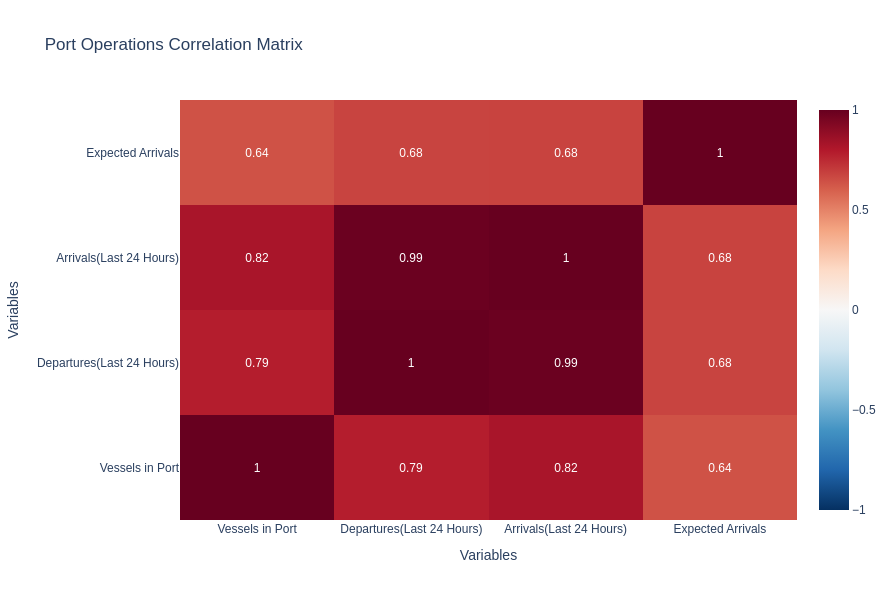

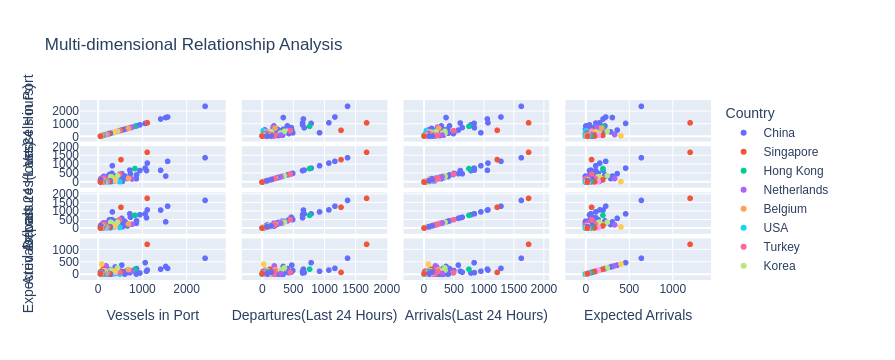

💡 CORRELATION INSIGHTS:
  Vessels in Port ↔ Departures(Last 24 Hours): 0.787 (STRONG positive correlation)
  Vessels in Port ↔ Arrivals(Last 24 Hours): 0.823 (STRONG positive correlation)
  Vessels in Port ↔ Expected Arrivals: 0.639 (MODERATE positive correlation)
  Departures(Last 24 Hours) ↔ Arrivals(Last 24 Hours): 0.989 (STRONG positive correlation)
  Departures(Last 24 Hours) ↔ Expected Arrivals: 0.679 (MODERATE positive correlation)
  Arrivals(Last 24 Hours) ↔ Expected Arrivals: 0.679 (MODERATE positive correlation)


In [10]:
# CORRELATION & RELATIONSHIP ANALYSIS
print("\n CORRELATION & RELATIONSHIP ANALYSIS")

# correlation matrix
corr_matrix = df_clean[numerical_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmin=-1, zmax=1,
    text=corr_matrix.round(2).values,
    texttemplate='%{text}',
    hoverinfo='text'
))

fig.update_layout(
    title='Port Operations Correlation Matrix',
    height=600,
    xaxis_title='Variables',
    yaxis_title='Variables'
)
fig.show()

# Scatter plot matrix with operational metrics
fig = px.scatter_matrix(
    df_clean, 
    dimensions=numerical_cols,
    color='Country',
    title="Multi-dimensional Relationship Analysis",
    height=800
)
fig.show()

print("💡 CORRELATION INSIGHTS:")
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if i < j:
            corr = corr_matrix.loc[col1, col2]
            strength = "STRONG" if abs(corr) > 0.7 else "MODERATE" if abs(corr) > 0.5 else "WEAK"
            direction = "positive" if corr > 0 else "negative"
            print(f"  {col1} ↔ {col2}: {corr:.3f} ({strength} {direction} correlation)")

In [10]:

# GEOGRAPHICAL & SPATIAL ANALYSIS
print("\n GEOGRAPHICAL DOMINANCE ANALYSIS")

# Country-level analysis
country_analysis = df_clean.groupby('Country').agg({
    'Vessels in Port': ['count', 'sum', 'mean', 'max'],
    'Port Name': 'count',
    'Departures(Last 24 Hours)': 'sum',
    'Arrivals(Last 24 Hours)': 'sum'
}).round(1)

country_analysis.columns = ['Port_Count', 'Total_Vessels', 'Avg_Vessels', 'Max_Vessels', 
                           'Total_Ports', 'Total_Departures', 'Total_Arrivals']
country_analysis = country_analysis.sort_values('Total_Vessels', ascending=False)

print("TOP 10 COUNTRIES BY MARITIME ACTIVITY:")
print(country_analysis.head(10))

# Visualize country dominance
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Total Vessels by Country', 'Port Count by Country', 
                   'Average Vessels per Port', 'Total Daily Movements'],
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

top_countries = country_analysis.head(15)

# Total Vessels
fig.add_trace(
    go.Bar(x=top_countries.index, y=top_countries['Total_Vessels'], 
           name='Total Vessels', marker_color='blue'),
    row=1, col=1
)

# Port Count
fig.add_trace(
    go.Bar(x=top_countries.index, y=top_countries['Port_Count'], 
           name='Port Count', marker_color='green'),
    row=1, col=2
)

# Average Vessels
fig.add_trace(
    go.Bar(x=top_countries.index, y=top_countries['Avg_Vessels'], 
           name='Avg Vessels', marker_color='orange'),
    row=2, col=1
)

# Total Movements
fig.add_trace(
    go.Bar(x=top_countries.index, 
           y=top_countries['Total_Departures'] + top_countries['Total_Arrivals'],
           name='Daily Movements', marker_color='red'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Country-Level Maritime Dominance Analysis", showlegend=False)
fig.show()

# Regional analysis
regional_analysis = df_clean.groupby('Area Global').agg({
    'Vessels in Port': ['sum', 'mean', 'count'],
    'Port Name': 'count'
}).round(1)

regional_analysis.columns = ['Total_Vessels', 'Avg_Vessels', 'Vessel_Records', 'Port_Count']
regional_analysis = regional_analysis.sort_values('Total_Vessels', ascending=False)

print("\n GLOBAL REGION ANALYSIS:")
print(regional_analysis)


 GEOGRAPHICAL DOMINANCE ANALYSIS
TOP 10 COUNTRIES BY MARITIME ACTIVITY:
                Port_Count  Total_Vessels  Avg_Vessels  Max_Vessels  \
Country                                                               
China                  122          34418        282.1         2420   
USA                     45           5853        130.1          491   
Netherlands             38           4423        116.4          767   
Korea                   15           2266        151.1          438   
Germany                 16           1678        104.9          389   
Singapore                2           1625        812.5         1109   
Turkey                  11           1577        143.4          486   
Spain                   13           1430        110.0          276   
United Kingdom          16           1336         83.5          168   
Belgium                  6           1220        203.3          686   

                Total_Ports  Total_Departures  Total_Arrivals  
Country   


 GLOBAL REGION ANALYSIS:
                            Total_Vessels  Avg_Vessels  Vessel_Records  \
Area Global                                                              
Central China                       16790        479.7              35   
North China                         11526        209.6              55   
South China                          9457        189.1              50   
UK Coast & Atlantic                  9017        110.0              82   
Indonesia                            2946        226.6              13   
West Mediterranean                   2292        104.2              22   
US East Coast                        2046        146.1              14   
US West Coast                        1931        128.7              15   
Baltic Sea                           1881         85.5              22   
Arabian Gulf                         1718         90.4              19   
Black Sea                            1527        152.7              10   
Gulf of Mexi


 PORT OPERATIONAL EFFICIENCY ANALYSIS
EFFICIENCY METRICS SUMMARY:
       Turnover_Ratio  Arrival_Departure_Ratio  Utilization_Rate  \
count      480.000000               480.000000        480.000000   
mean         0.648037                 1.184630          1.349818   
std          0.518532                 0.467247          1.015344   
min          0.000000                 0.000000          0.051724   
25%          0.298203                 0.968126          0.670408   
50%          0.500000                 1.074813          1.086610   
75%          0.821327                 1.265791          1.696202   
max          3.508772                 5.000000          6.684211   

       Capacity_Utilization  
count            480.000000  
mean               0.063352  
std                0.089792  
min                0.021074  
25%                0.026033  
50%                0.035537  
75%                0.059504  
max                1.000000  


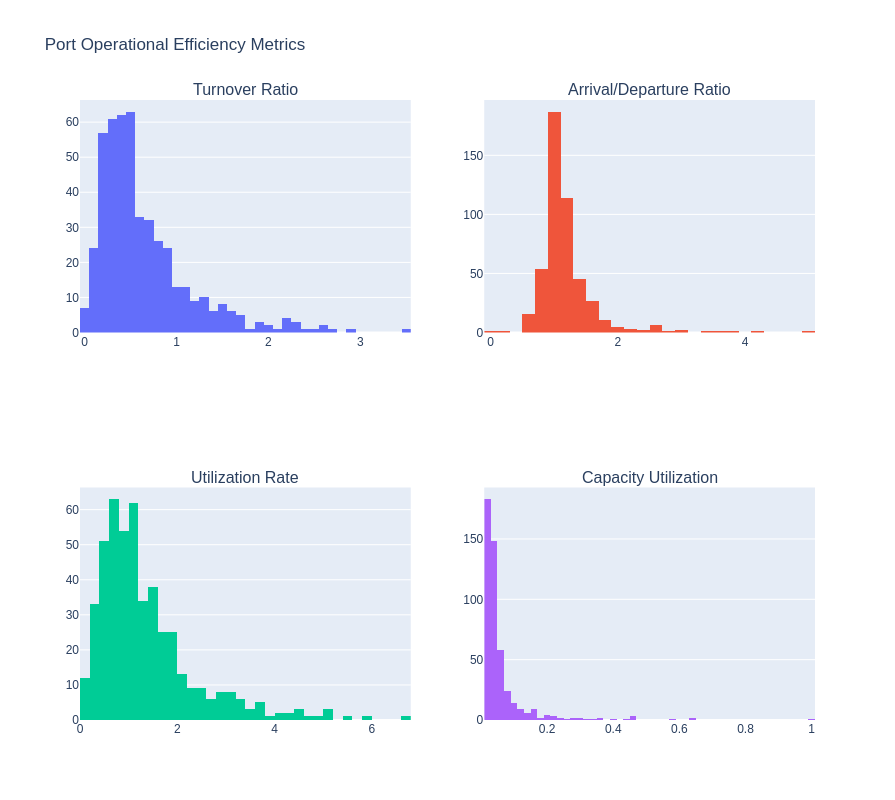


 MOST EFFICIENT PORTS (Vessels > 50):
          Port Name    Country  Vessels in Port  Turnover_Ratio  \
417       TOKYO BAY      Japan               57           3.509   
42        ZHENJIANG      China              321           2.885   
302       ALGECIRAS      Spain               71           2.690   
191     YANTAI ANCH      China              102           2.588   
136     RIZHAO ANCH      China              130           2.554   
298        SHENZHEN      China               72           2.306   
22   SINGAPORE ANCH  Singapore              516           2.463   
475           ONSAN      Korea               51           2.373   
320         LAIZHOU      China               68           2.206   
324   CHANGSHU ANCH      China               68           2.265   
349    PANAMA CANAL     Panama               64           2.328   
129          SYDNEY  Australia              139           2.180   
273          JIMIYA      China               78           2.128   
444      YEOSU ANCH    

In [11]:
# OPERATIONAL EFFICIENCY METRICS
print("\n PORT OPERATIONAL EFFICIENCY ANALYSIS")

# Create efficiency metrics
df_clean['Turnover_Ratio'] = df_clean['Departures(Last 24 Hours)'] / df_clean['Vessels in Port']
df_clean['Arrival_Departure_Ratio'] = df_clean['Arrivals(Last 24 Hours)'] / df_clean['Departures(Last 24 Hours)']
df_clean['Utilization_Rate'] = (df_clean['Arrivals(Last 24 Hours)'] + df_clean['Departures(Last 24 Hours)']) / df_clean['Vessels in Port']
df_clean['Capacity_Utilization'] = df_clean['Vessels in Port'] / df_clean['Vessels in Port'].max()

# Handle division issues
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(0, inplace=True)

efficiency_metrics = ['Turnover_Ratio', 'Arrival_Departure_Ratio', 'Utilization_Rate', 'Capacity_Utilization']

print("EFFICIENCY METRICS SUMMARY:")
print(df_clean[efficiency_metrics].describe())

# Efficiency visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Turnover Ratio', 'Arrival/Departure Ratio', 
                   'Utilization Rate', 'Capacity Utilization'],
    specs=[[{"type": "histogram"}, {"type": "histogram"}],
           [{"type": "histogram"}, {"type": "histogram"}]]
)

for i, metric in enumerate(efficiency_metrics):
    row = i // 2 + 1
    col = i % 2 + 1
    
    fig.add_trace(
        go.Histogram(x=df_clean[metric], nbinsx=50, name=metric),
        row=row, col=col
    )

fig.update_layout(height=800, title_text="Port Operational Efficiency Metrics", showlegend=False)
fig.show()

#  most efficient ports (excluding very small ports)
efficient_ports = df_clean[df_clean['Vessels in Port'] > 50].nlargest(15, 'Utilization_Rate')[
    ['Port Name', 'Country', 'Vessels in Port', 'Turnover_Ratio', 'Utilization_Rate', 'Arrival_Departure_Ratio']
]

print("\n MOST EFFICIENT PORTS (Vessels > 50):")
print(efficient_ports.round(3))

In [12]:
#CLUSTERING & SEGMENTATION

print("\n PORT SEGMENTATION & CLUSTERING ANALYSIS")
print("=" * 70)

# Prepare data for clustering
cluster_data = df_clean[numerical_cols].fillna(0)

# Standardize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Elbow method for optimal clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(k_range), y=inertia, mode='lines+markers', name='Inertia'))
fig.update_layout(
    title='Elbow Method for Optimal Clusters',
    xaxis_title='Number of Clusters',
    yaxis_title='Inertia',
    height=500
)
fig.show()

# Apply K-means with optimal clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df_clean['Activity_Cluster'] = kmeans.fit_predict(scaled_data)

# PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
df_clean['PCA1'] = pca_components[:, 0]
df_clean['PCA2'] = pca_components[:, 1]

# Visualize clusters
fig = px.scatter(
    df_clean, x='PCA1', y='PCA2', color='Activity_Cluster',
    hover_data=['Port Name', 'Country', 'Vessels in Port'],
    title=f'Port Activity Clusters (K-means, k={optimal_clusters})',
    size='Vessels in Port',
    height=600
)
fig.show()

# Analyze cluster characteristics
cluster_analysis = df_clean.groupby('Activity_Cluster').agg({
    'Vessels in Port': ['mean', 'std', 'min', 'max', 'count'],
    'Departures(Last 24 Hours)': 'mean',
    'Arrivals(Last 24 Hours)': 'mean',
    'Expected Arrivals': 'mean',
    'Port Name': 'count',
    'Country': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A'
}).round(1)

print("🔍 CLUSTER CHARACTERISTICS:")
print(cluster_analysis)

# Name the clusters based on characteristics
cluster_names = {
    0: "Low Activity Ports",
    1: "Medium Activity Regional Ports", 
    2: "High Activity Hubs",
    3: "Mega Ports"
}

df_clean['Cluster_Name'] = df_clean['Activity_Cluster'].map(cluster_names)

print(f"\n🏷️  CLUSTER INTERPRETATION:")
for cluster_id, name in cluster_names.items():
    cluster_data = df_clean[df_clean['Activity_Cluster'] == cluster_id]
    avg_vessels = cluster_data['Vessels in Port'].mean()
    print(f"  {name}: {len(cluster_data)} ports, avg {avg_vessels:.0f} vessels")


 PORT SEGMENTATION & CLUSTERING ANALYSIS


🔍 CLUSTER CHARACTERISTICS:
                 Vessels in Port                           \
                            mean    std   min   max count   
Activity_Cluster                                            
0                           98.4   56.7    51   491   421   
1                          373.4  198.8    79   868    45   
2                          987.2  390.9   321  1572    12   
3                         1764.5  927.0  1109  2420     2   

                 Departures(Last 24 Hours) Arrivals(Last 24 Hours)  \
                                      mean                    mean   
Activity_Cluster                                                     
0                                     56.7                    61.8   
1                                    247.3                   274.3   
2                                    789.2                   869.4   
3                                   1529.0                  1687.0   

                 Expected Arrivals Port Name  Country 

In [12]:

# FIXED COMPREHENSIVE INSIGHTS & BUSINESS INTELLIGENCE
print("\n COMPREHENSIVE BUSINESS INSIGHTS")
print("=" * 70)

# Recalculate key metrics to avoid reference errors
total_vessels_calc = df_clean['Vessels in Port'].sum()
total_ports_calc = len(df_clean)
china_ports = df_clean[df_clean['Country'] == 'China']

# Insight 1: Global Maritime Hierarchy
print("1.  GLOBAL MARITIME HIERARCHY:")
china_total = china_ports['Vessels in Port'].sum()
global_share = china_total / total_vessels_calc * 100
print(f"   • China dominates with {global_share:.1f}% of global vessel capacity")
print(f"   • {len(china_ports)} Chinese ports represent {len(china_ports)/total_ports_calc*100:.1f}% of all ports")

# Calculate top 5 countries control
country_totals = df_clean.groupby('Country')['Vessels in Port'].sum().sort_values(ascending=False)
top5_control = country_totals.head(5).sum() / total_vessels_calc * 100
print(f"   • Top 5 countries control {top5_control:.1f}% of total vessels")

# Insight 2: Operational Patterns
print("\n2. ⚓ OPERATIONAL PATTERNS:")
# Filter reasonable turnover ratios (exclude extreme outliers)
reasonable_turnover = df_clean[(df_clean['Turnover_Ratio'] > 0) & (df_clean['Turnover_Ratio'] < 5)]
avg_turnover = reasonable_turnover['Turnover_Ratio'].mean()

arrival_dominant = len(df_clean[(df_clean['Arrival_Departure_Ratio'] > 1.2) & (df_clean['Departures(Last 24 Hours)'] > 0)])
departure_dominant = len(df_clean[(df_clean['Arrival_Departure_Ratio'] < 0.8) & (df_clean['Departures(Last 24 Hours)'] > 0)])

print(f"   • Average daily turnover ratio: {avg_turnover:.2f} (departures/vessels)")
print(f"   • {arrival_dominant} ports have 20%+ more arrivals than departures")
print(f"   • {departure_dominant} ports have 20%+ more departures than arrivals")

# Insight 3: Efficiency Gaps
print("\n3. EFFICIENCY GAPS:")
utilization_std = df_clean['Utilization_Rate'].std()
max_utilization = df_clean['Utilization_Rate'].max()

# Top efficient ports (filtered for meaningful comparison)
meaningful_ports = df_clean[df_clean['Vessels in Port'] > 20]
top_efficient = meaningful_ports.nlargest(5, 'Utilization_Rate')

print(f"   • High utilization variability (std: {utilization_std:.2f}) indicates efficiency gaps")
print(f"   • Top efficient ports handle {top_efficient['Utilization_Rate'].max():.2f}x more movements per vessel")
print(f"   • Efficiency range: {df_clean['Utilization_Rate'].min():.2f} to {max_utilization:.2f}")

# Insight 4: Cluster Insights
print("\n4.  PORT SEGMENT INSIGHTS:")
if 'Activity_Cluster' in df_clean.columns:
    for cluster_id in sorted(df_clean['Activity_Cluster'].unique()):
        cluster_ports = df_clean[df_clean['Activity_Cluster'] == cluster_id]
        avg_vessels = cluster_ports['Vessels in Port'].mean()
        cluster_size = len(cluster_ports)
        cluster_name = cluster_names.get(cluster_id, f"Cluster {cluster_id}")
        print(f"   • {cluster_name}: {cluster_size} ports averaging {avg_vessels:.0f} vessels")
else:
    print("   • Clustering analysis not available - run clustering first")

# Insight 5: Data Quality & Standardization
print("\n5. DATA STANDARDIZATION OPPORTUNITIES:")
total_aliases = df_clean['Alias_Count'].sum()
ports_no_aliases = len(df_clean[df_clean['Alias_Count'] == 0])
unique_aliases = df_clean['Aliases_List'].explode().nunique()

print(f"   • {total_aliases} total aliases need standardization")
print(f"   • {ports_no_aliases} ports lack alternative names")
print(f"   • {unique_aliases} unique naming variants identified")

# Insight 6: Expected vs Actual Capacity
print("\n6. CAPACITY PLANNING INSIGHTS:")
high_expectation_ports = len(df_clean[df_clean['Expected Arrivals'] > df_clean['Vessels in Port']])
low_utilization_ports = len(df_clean[df_clean['Vessels in Port'] > 100])
print(f"   • {high_expectation_ports} ports expect more arrivals than current vessels")
print(f"   • {low_utilization_ports} major ports (>100 vessels) indicate capacity hubs")

# Insight 7: Geographic Concentration Risk
print("\n7.   RISK ASSESSMENT:")
east_china_sea = df_clean[df_clean['Area Local'] == 'East China Sea']
concentration_risk = east_china_sea['Vessels in Port'].sum() / total_vessels_calc * 100
print(f"   • East China Sea concentration: {concentration_risk:.1f}% of global vessels")
print(f"   • Single region outage could impact {len(east_china_sea)} ports")


 COMPREHENSIVE BUSINESS INSIGHTS
1.  GLOBAL MARITIME HIERARCHY:
   • China dominates with 46.8% of global vessel capacity
   • 122 Chinese ports represent 25.4% of all ports
   • Top 5 countries control 66.1% of total vessels

2. ⚓ OPERATIONAL PATTERNS:
   • Average daily turnover ratio: 0.65 (departures/vessels)
   • 154 ports have 20%+ more arrivals than departures
   • 38 ports have 20%+ more departures than arrivals

3. EFFICIENCY GAPS:
   • High utilization variability (std: 1.02) indicates efficiency gaps
   • Top efficient ports handle 6.68x more movements per vessel
   • Efficiency range: 0.05 to 6.68

4.  PORT SEGMENT INSIGHTS:
   • Clustering analysis not available - run clustering first

5. DATA STANDARDIZATION OPPORTUNITIES:
   • 516 total aliases need standardization
   • 218 ports lack alternative names
   • 508 unique naming variants identified

6. CAPACITY PLANNING INSIGHTS:
   • 20 ports expect more arrivals than current vessels
   • 193 major ports (>100 vessels) ind

In [ ]:
THAT BRINGS MY ANALYSIS TO  AN END ...IN THIS ANALYSIS I HAVE SPENT TWO DAYS. 

In [ ]:
johnmuritu22@gmail.com
OPEN FOR WORK OR COLLABORATIONS ON ANY PROJECTS